# Music multi-classifier

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model 
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

## Read dataset

In [2]:
df = pd.read_csv('features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

## Look at the data

In [3]:
df.shape

(9990, 60)

In [4]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

### Remove filename column

In [5]:
df = df.drop(labels='filename',axis=1)

### See audio files info

In [6]:
audio= 'genres/rock/rock.00001.wav'
data, sr = librosa.load(audio)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
librosa.load(audio, sr=45600)

(array([0.36035496, 0.5511149 , 0.64852196, ..., 0.06547201, 0.0543708 ,
        0.02690102], dtype=float32),
 45600)

### Display Audio

In [8]:
import IPython
IPython.display.Audio(data, rate=sr)

### Visualizing the file

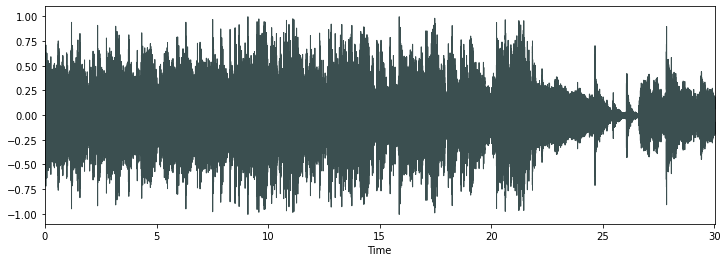

In [9]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, color = '#3B4F50')
plt.show()

### Spectogram

C:\ProgramData\Anaconda3\lib\site-packages\librosa\display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


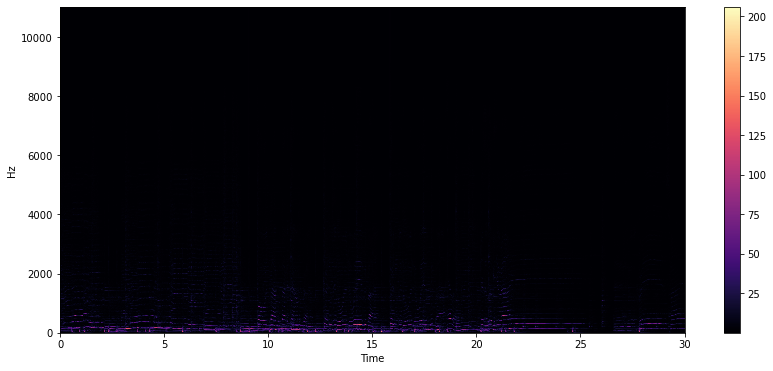

In [10]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft, sr= sr, x_axis='time', y_axis='hz')
plt.colorbar()

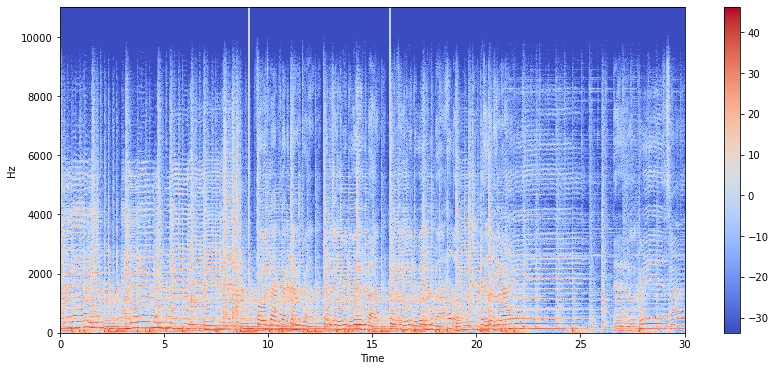

In [11]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db, sr= sr, x_axis='time', y_axis='hz')
plt.colorbar()

### Spectral Rollof

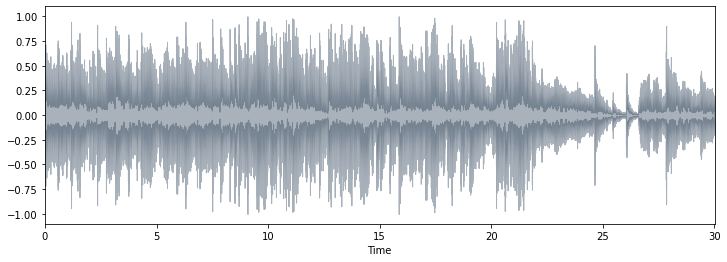

In [12]:
from sklearn.preprocessing import normalize
spectral_rollof = librosa.feature.spectral_rolloff(data+0.01, sr = sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr= sr, alpha=0.4, color='#2A3F55')

### Chroma feature

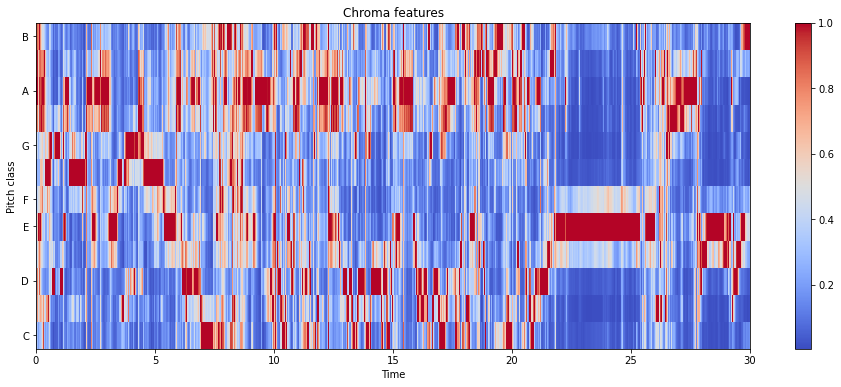

In [13]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(data, sr = sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chroma features')
plt.show()

### Zero crossing rate

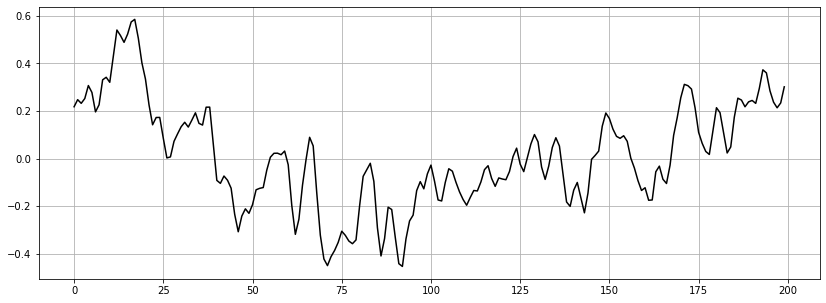

In [14]:
start= 1000
end = 1200
plt.figure(figsize=(14,5))
plt.plot(data[start:end], color= '#000000')
plt.grid()

In [15]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print ('Number of zero-crossings: ', sum(zero_cross_rate))

Number of zero-crossings:  14


# Feature extraction

### Withouth One Hot Encoding

In [16]:
class_list = df.iloc[:,-1]
label_convertor = LabelEncoder()

In [17]:
y = label_convertor.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

# Scaling features

In [18]:
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:,:-1], dtype = float))

# Training and test data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print(len(y_train))
print(len(y_test))

7992
1998


# Build Model

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [21]:
model = keras.models.Sequential()

### Add layers

In [22]:
model.add(Dense(units= 600,activation='relu',input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=10, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               35400     
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               240400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               120300    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               3

### Compile model

In [23]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                      metrics = ['accuracy'])

### Train model

In [24]:
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                            batch_size = 128, epochs = 50)

checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model.fit(
                    X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=150, 
                    callbacks = [checkpointer], 
                    validation_data = (X_test, y_test)
                    )

Epoch 1/50
49/54 [==========================>...] - ETA: 0s - loss: 1.7466 - accuracy: 0.3698
Epoch 00001: val_accuracy improved from -inf to 0.60811, saving model to weights.hdf5
54/54 [==============================] - 2s 20ms/step - loss: 1.7177 - accuracy: 0.3816 - val_loss: 1.1237 - val_accuracy: 0.6081
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 1.1872 - accuracy: 0.5916
Epoch 00002: val_accuracy improved from 0.60811 to 0.70971, saving model to weights.hdf5
54/54 [==============================] - 1s 13ms/step - loss: 1.1872 - accuracy: 0.5916 - val_loss: 0.8785 - val_accuracy: 0.7097
Epoch 3/50
53/54 [============================>.] - ETA: 0s - loss: 0.9256 - accuracy: 0.6864
Epoch 00003: val_accuracy improved from 0.70971 to 0.76476, saving model to weights.hdf5
54/54 [==============================] - 1s 15ms/step - loss: 0.9273 - accuracy: 0.6858 - val_loss: 0.6900 - val_accuracy: 0.7648
Epoch 4/50
49/54 [==========================>...] - ETA: 0s - lo

51/54 [===========================>..] - ETA: 0s - loss: 0.1082 - accuracy: 0.9671
Epoch 00028: val_accuracy improved from 0.92543 to 0.92743, saving model to weights.hdf5
54/54 [==============================] - 1s 15ms/step - loss: 0.1091 - accuracy: 0.9666 - val_loss: 0.2999 - val_accuracy: 0.9274
Epoch 29/50
52/54 [===========================>..] - ETA: 0s - loss: 0.1009 - accuracy: 0.9682
Epoch 00029: val_accuracy did not improve from 0.92743
54/54 [==============================] - 1s 9ms/step - loss: 0.1006 - accuracy: 0.9685 - val_loss: 0.2979 - val_accuracy: 0.9224
Epoch 30/50
53/54 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.9697
Epoch 00030: val_accuracy did not improve from 0.92743
54/54 [==============================] - 0s 9ms/step - loss: 0.0981 - accuracy: 0.9698 - val_loss: 0.3408 - val_accuracy: 0.9169
Epoch 31/50
52/54 [===========================>..] - ETA: 0s - loss: 0.0940 - accuracy: 0.9726
Epoch 00031: val_accuracy did not improve fro

### Save the model

In [25]:
model_name = "Music_model.h5"
model.save(model_name)
model = load_model(model_name)

### Model evaluation

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=100)
print('test_loss: ', test_loss)
print('test acc: ', test_acc*100)

20/20 [==============================] - 0s 3ms/step - loss: 0.2867 - accuracy: 0.9344
test_loss:  0.2867031991481781
test acc:  93.44344139099121


In [27]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = label_convertor.inverse_transform(y_pred)

### Confusion matrix

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = label_convertor.inverse_transform(y_pred)

test_y = label_convertor.inverse_transform(y_test)

cm = confusion_matrix(y_pred, test_y) # look into this
cm

array([[200,   0,   6,   0,   2,   4,   3,   0,   3,   2],
       [  0, 224,   1,   0,   1,   2,   0,   1,   0,   2],
       [  6,   1, 175,   1,   3,   3,   0,   1,   2,   2],
       [  0,   0,   0, 184,   5,   0,   1,   4,   3,   6],
       [  1,   0,   1,   2, 189,   0,   1,   0,   0,   1],
       [  0,   9,   3,   0,   0, 188,   0,   2,   2,   1],
       [  0,   0,   0,   1,   0,   0, 188,   0,   1,   6],
       [  0,   0,   0,   1,   7,   0,   0, 178,   1,   3],
       [  0,   0,   1,   1,   3,   0,   0,   2, 165,   6],
       [  0,   0,   5,   1,   0,   0,   1,   0,   3, 176]], dtype=int64)

## Try with one hot encoding

In [29]:
Y_ohe = LabelEncoder()
Y_ohe.fit(y)
ohe = Y_ohe.transform(y)
ohe = np_utils.to_categorical(y)
ohe

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,ohe, test_size=0.2)
print(len(y_train))
print(len(y_test))

7992
1998


### Train a new model OHE

In [31]:
model_ohe = keras.models.Sequential()

In [32]:
model_ohe.add(Dense(units= 600,activation='relu',input_shape=(X_train.shape[1],)))
model_ohe.add(Dropout(0.2))
model_ohe.add(Dense(units=400, activation='relu'))
model_ohe.add(Dropout(0.2))
model_ohe.add(Dense(units=50, activation='relu'))
model_ohe.add(Dropout(0.2))

model_ohe.add(Dense(units=10, activation='softmax'))

print(model_ohe.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 600)               35400     
                                                                 
 dropout_5 (Dropout)         (None, 600)               0         
                                                                 
 dense_7 (Dense)             (None, 400)               240400    
                                                                 
 dropout_6 (Dropout)         (None, 400)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                20050     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 10)               

In [33]:
model_ohe.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])

In [34]:
checkpointer_ohe = ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history_ohe = model_ohe.fit(
                    X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=150, 
                    callbacks = [checkpointer_ohe], 
                    validation_data = (X_test, y_test)
                    )

Epoch 1/50
53/54 [============================>.] - ETA: 0s - loss: 1.4411 - accuracy: 0.4879
Epoch 00001: val_accuracy improved from -inf to 0.65816, saving model to weights.hdf5
54/54 [==============================] - 1s 12ms/step - loss: 1.4373 - accuracy: 0.4894 - val_loss: 1.0065 - val_accuracy: 0.6582
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.9632 - accuracy: 0.6694
Epoch 00002: val_accuracy improved from 0.65816 to 0.73724, saving model to weights.hdf5
54/54 [==============================] - 1s 10ms/step - loss: 0.9632 - accuracy: 0.6694 - val_loss: 0.7860 - val_accuracy: 0.7372
Epoch 3/50
53/54 [============================>.] - ETA: 0s - loss: 0.7919 - accuracy: 0.7342
Epoch 00003: val_accuracy improved from 0.73724 to 0.77077, saving model to weights.hdf5
54/54 [==============================] - 1s 11ms/step - loss: 0.7915 - accuracy: 0.7340 - val_loss: 0.6946 - val_accuracy: 0.7708
Epoch 4/50
54/54 [==============================] - ETA: 0s - lo

Epoch 29/50
51/54 [===========================>..] - ETA: 0s - loss: 0.0990 - accuracy: 0.9694
Epoch 00029: val_accuracy did not improve from 0.90591
54/54 [==============================] - 0s 7ms/step - loss: 0.0985 - accuracy: 0.9697 - val_loss: 0.3413 - val_accuracy: 0.9029
Epoch 30/50
50/54 [==========================>...] - ETA: 0s - loss: 0.0893 - accuracy: 0.9708
Epoch 00030: val_accuracy improved from 0.90591 to 0.91491, saving model to weights.hdf5
54/54 [==============================] - 1s 10ms/step - loss: 0.0891 - accuracy: 0.9708 - val_loss: 0.3400 - val_accuracy: 0.9149
Epoch 31/50
53/54 [============================>.] - ETA: 0s - loss: 0.0780 - accuracy: 0.9752
Epoch 00031: val_accuracy did not improve from 0.91491
54/54 [==============================] - 0s 7ms/step - loss: 0.0778 - accuracy: 0.9754 - val_loss: 0.3301 - val_accuracy: 0.9139
Epoch 32/50
53/54 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9787
Epoch 00032: val_accuracy did not

In [35]:
model_ohe_name = "Music_model_ohe.h5"
model_ohe.save(model_ohe_name)
model_ohe = load_model(model_ohe_name)

In [36]:
test_loss, test_acc = model_ohe.evaluate(X_test, y_test, batch_size=100)
print('test_loss: ', test_loss)
print('test acc: ', test_acc*100)

20/20 [==============================] - 0s 2ms/step - loss: 0.3740 - accuracy: 0.9159
test_loss:  0.37403056025505066
test acc:  91.59159064292908


In [37]:
y_pred = model_ohe.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = Y_ohe.inverse_transform(y_pred)

Y = np.argmax(ohe, axis = 1) 
Y = Y_ohe.inverse_transform(Y)

test_y = np.argmax(y_test, axis = 1) 
test_y = Y_ohe.inverse_transform(test_y)

cm = confusion_matrix(y_pred, test_y) # look into this
cm

array([[190,   0,   4,   2,   0,   4,   4,   0,   0,   3],
       [  0, 168,   2,   1,   0,   7,   0,   1,   0,   0],
       [  3,   1, 163,   5,   3,   1,   0,   6,   3,   5],
       [  0,   1,   0, 183,   1,   1,   0,   4,   3,   3],
       [  0,   0,   1,   5, 168,   0,   0,   2,   2,   2],
       [  4,   7,   9,   0,   0, 204,   0,   0,   1,   2],
       [  2,   0,   0,   1,   1,   0, 195,   0,   0,   7],
       [  0,   0,   2,   2,   3,   0,   0, 210,   2,   3],
       [  0,   0,   5,   1,   3,   1,   0,   5, 183,   6],
       [  0,   0,   5,   6,   0,   1,   5,   3,   1, 166]], dtype=int64)

### Predict from test_music

In [53]:
audio1= 'Test_songs/song1.wav'
audio2= 'Test_songs/song2.wav'
audio3= 'Test_songs/song3.wav'
audio4= 'Test_songs/song4.wav'
audio5= 'Test_songs/song5.wav'
audio6= 'Test_songs/song6.wav'
audio7= 'Test_songs/song7.wav'
audio8= 'Test_songs/song8.wav'

data1, sr1 = librosa.load(audio1)
data2, sr2 = librosa.load(audio2)
data3, sr3 = librosa.load(audio3)
data4, sr4 = librosa.load(audio4)
data5, sr5 = librosa.load(audio5)
data6, sr6 = librosa.load(audio6)
data7, sr7 = librosa.load(audio7)
data8, sr8 = librosa.load(audio8)
#print(type(data), type(sr))

In [54]:
IPython.display.Audio(data1, rate=sr1)

In [55]:
#harmony_mean, perceptr_mean = librosa.effects.hpss(data).
#harmony_var, perceptr_var = librosa.effects.hpss(data)
#harmony_mean = librosa.effects.harmonic(data).var()


#freqs = librosa.core.fft_frequencies(sr=sr)
#perceptr_mean = librosa.perceptual_weighting(abs(X)**2, freqs)
#perceptr_mean

### Extract features

In [40]:
def extract_features (data, sr):
    chroma_stft_mean = librosa.feature.chroma_stft(data, sr = sr).mean()
    chroma_stft_var = librosa.feature.chroma_stft(data, sr = sr).var()
    #print('chroma_stft_mean: ',chroma_stft_mean)
    #print('chroma_stft_var: ',chroma_stft_var)
    
    rms_mean = librosa.feature.rms(data).mean()
    rms_var = librosa.feature.rms(data).var()
    #print('rms_mean: ',rms_mean)
    #print('rms_var: ',rms_var)
    
    spectral_centroid_mean = librosa.feature.spectral_centroid(data, sr = sr).mean()
    spectral_centroid_var = librosa.feature.spectral_centroid(data, sr = sr).var()
    #print('spectral_centroid_mean: ',spectral_centroid_mean)
    #print('spectral_centroid_var: ',spectral_centroid_var)
    
    spectral_bandwidth_mean = librosa.feature.spectral_bandwidth(data, sr = sr).mean()
    spectral_bandwidth_var = librosa.feature.spectral_bandwidth(data, sr = sr).var()
    #print('spectral_bandwidth_mean: ',spectral_bandwidth_mean)
    #print('spectral_bandwidth_var: ',spectral_bandwidth_var)
    
    spectral_rolloff_mean = librosa.feature.spectral_rolloff(data, sr = sr).mean()
    spectral_rolloff_var = librosa.feature.spectral_rolloff(data, sr = sr).var()
    #print('spectral_rolloff_mean: ',spectral_rolloff_mean)
    #print('spectral_rolloff_var: ',spectral_rolloff_var)
    
    zero_crossing_rate_mean = librosa.feature.zero_crossing_rate(data).mean()
    zero_crossing_rate_var = librosa.feature.zero_crossing_rate(data).var()
    #print('zero_crossing_rate_mean: ',zero_crossing_rate_mean)
    #print('zero_crossing_rate_var: ',zero_crossing_rate_var)
    
    #NEED TO CHAGE TO HARMONY
    harmony_mean = librosa.effects.harmonic(data).mean()
    harmony_var = librosa.effects.harmonic(data).var()
    #print('harmony_mean: ',rms_mean)
    #print('zero_crossing_rate_var: ',rms_var)
    
    #NEED TO CHANGE TO PERCEPTR
    #zero_crossing_rate = librosa.feature.zero_crossing_rate(data).mean()
    #zero_crossing_rate = librosa.feature.zero_crossing_rate(data).var()
    #print('zero_crossing_rate_mean: ',rms_mean)
    #print('zero_crossing_rate_var: ',rms_var)
    
    #JUST ONE TEMPO
    tempogram_mean = librosa.feature.tempogram(data, sr = sr).mean()
    tempogram_var= librosa.feature.tempogram(data, sr = sr).var()
    #print('tempogram_mean: ',tempogram_mean)
    #print('tempogram_var: ',rms_var)
    
    mfcc = librosa.feature.mfcc(data, sr = sr, n_mfcc=20)
    mfcc_mean_list=[]
    mfcc_var_list=[]
    for n in mfcc:
        #print('mfcc: ',n)
        mfcc_mean_list.append(n.mean())
        mfcc_var_list.append(n.var())
    #print('mfcc_mean_list: ',mfcc_mean_list)
    #print('mfcc_var_list: ',mfcc_var_list)
    
    features = np.array(
    [66149,
     chroma_stft_mean,
     chroma_stft_var,
     rms_mean,
     rms_var,
     spectral_centroid_mean,
     spectral_centroid_var,
     spectral_bandwidth_mean,
     spectral_bandwidth_var,
     spectral_rolloff_mean,
     spectral_rolloff_var,
     zero_crossing_rate_mean,
     zero_crossing_rate_var,
     harmony_mean,
     harmony_var,
     0,
     0,
     tempogram_mean,
     mfcc_mean_list[0],
     mfcc_var_list[0],
     mfcc_mean_list[1],
     mfcc_var_list[1],
     mfcc_mean_list[2],
     mfcc_var_list[2],
     mfcc_mean_list[3],
     mfcc_var_list[3],
     mfcc_mean_list[4],
     mfcc_var_list[4],
     mfcc_mean_list[5],
     mfcc_var_list[5],
     mfcc_mean_list[6],
     mfcc_var_list[6],
     mfcc_mean_list[7],
     mfcc_var_list[7],
     mfcc_mean_list[8],
     mfcc_var_list[8],
     mfcc_mean_list[9],
     mfcc_var_list[9],
     mfcc_mean_list[10],
     mfcc_var_list[10],
     mfcc_mean_list[11],
     mfcc_var_list[11],
     mfcc_mean_list[12],
     mfcc_var_list[12],
     mfcc_mean_list[13],
     mfcc_var_list[13],
     mfcc_mean_list[14],
     mfcc_var_list[14],
     mfcc_mean_list[15],
     mfcc_var_list[15],
     mfcc_mean_list[16],
     mfcc_var_list[16],
     mfcc_mean_list[17],
     mfcc_var_list[17],
     mfcc_mean_list[18],
     mfcc_var_list[18],
     mfcc_mean_list[19],
     mfcc_var_list[19],
    ], dtype=float)
    
    return features

In [55]:
test_song1= extract_features(data1, sr1)
test_song2= extract_features(data2, sr2)
test_song3= extract_features(data3, sr3)
test_song4= extract_features(data4, sr4)
test_song5= extract_features(data5, sr5)
test_song6= extract_features(data6, sr6)
test_song7= extract_features(data7, sr7)
test_song8= extract_features(data8, sr8)
print('Features_song_1: ',test_song1)
print('Features_song_2: ',test_song2)
print('Features_song_3: ',test_song3)
print('Features_song_4: ',test_song4)
print('Features_song_5: ',test_song5)
print('Features_song_6: ',test_song6)
print('Features_song_7: ',test_song7)
print('Features_song_8: ',test_song8)

Features_song_1:  [ 6.61490000e+04  3.64515156e-01  7.40006045e-02  2.03558773e-01
  1.24376710e-03  2.62662918e+03  1.27970918e+05  2.62041491e+03
  5.38260696e+04  5.59333363e+03  9.18668398e+05  1.32019043e-01
  6.90248609e-04  5.76733373e-06  2.54786890e-02  0.00000000e+00
  0.00000000e+00  2.19115420e-01 -7.27101755e+00  6.08485229e+02
  8.04709625e+01  1.79253784e+02 -8.56692696e+00  9.57136612e+01
  2.11341305e+01  4.97589111e+01  3.00331974e+00  3.67919044e+01
  4.10791016e+00  3.44686317e+01 -1.23414136e-01  2.72855225e+01
  4.25862741e+00  2.92010555e+01 -2.62128401e+00  3.65502167e+01
  1.02454205e+01  3.88722038e+01  3.27379763e-01  3.63748055e+01
  2.79747200e+00  3.57923431e+01 -7.24791193e+00  3.59465866e+01
  1.02330852e+00  4.04276123e+01  5.26325703e-02  3.99670258e+01
  4.20534039e+00  4.02804642e+01 -3.95285177e+00  3.55780334e+01
  3.53223419e+00  4.54535294e+01 -5.60631931e-01  5.87077560e+01
  4.22368860e+00  8.51427765e+01]
Features_song_2:  [ 6.61490000e+04  5.

In [56]:
songs= np.array([test_song1,test_song2,test_song3,test_song4,test_song5,test_song6,test_song7,test_song8])
songs

array([[ 6.61490000e+04,  3.64515156e-01,  7.40006045e-02,
         2.03558773e-01,  1.24376710e-03,  2.62662918e+03,
         1.27970918e+05,  2.62041491e+03,  5.38260696e+04,
         5.59333363e+03,  9.18668398e+05,  1.32019043e-01,
         6.90248609e-04,  5.76733373e-06,  2.54786890e-02,
         0.00000000e+00,  0.00000000e+00,  2.19115420e-01,
        -7.27101755e+00,  6.08485229e+02,  8.04709625e+01,
         1.79253784e+02, -8.56692696e+00,  9.57136612e+01,
         2.11341305e+01,  4.97589111e+01,  3.00331974e+00,
         3.67919044e+01,  4.10791016e+00,  3.44686317e+01,
        -1.23414136e-01,  2.72855225e+01,  4.25862741e+00,
         2.92010555e+01, -2.62128401e+00,  3.65502167e+01,
         1.02454205e+01,  3.88722038e+01,  3.27379763e-01,
         3.63748055e+01,  2.79747200e+00,  3.57923431e+01,
        -7.24791193e+00,  3.59465866e+01,  1.02330852e+00,
         4.04276123e+01,  5.26325703e-02,  3.99670258e+01,
         4.20534039e+00,  4.02804642e+01, -3.95285177e+0

### Scale values and predict

In [57]:
fit = StandardScaler()
t = fit.fit_transform(np.array(songs, dtype = float))
t

array([[ 0.        ,  0.23368065, -1.11552007, -0.06825675, -0.6965415 ,
         0.24373305, -0.93167358,  0.28928277, -0.69432378,  0.27869215,
        -0.62453245,  0.48364113, -1.32237168,  0.67448667, -0.31134088,
         0.        ,  0.        ,  0.63160217,  0.77144235, -1.09628566,
         0.08299786, -0.97222559, -0.38824568, -1.38614758, -0.39151295,
        -1.18437149,  0.06052661, -1.52416243,  0.03228609, -1.25879918,
         0.01676431, -1.60184633,  0.25246632, -1.20272191,  0.21958285,
        -1.40413271,  1.770475  , -1.07930742,  1.19167347, -0.99412888,
         0.02453683, -1.16265879, -0.68764705, -1.16634641, -0.05096331,
        -1.12219198,  0.4103072 , -1.09371888,  0.45723278, -0.79564966,
        -0.17123997, -1.36898401, -0.18633254, -0.68330622, -0.21423692,
        -0.52340619, -0.25198304, -0.23647714],
       [ 0.        ,  1.88278402, -0.62939238,  1.74149938,  1.08510287,
         1.95033803, -0.45236101,  1.87006368, -0.86778111,  1.97935376,
   

## Predictions with both models

In [58]:
predictions = model.predict(t)
predictions

array([[1.0045381e-02, 1.0307097e-02, 8.6880215e-03, 3.0774379e-01,
        1.5159264e-02, 6.8891961e-03, 1.7700739e-01, 9.8359426e-03,
        6.0167769e-03, 4.4830716e-01],
       [2.6492416e-03, 1.6179013e-04, 1.2660815e-04, 1.9643294e-02,
        9.7036463e-01, 2.4724633e-05, 2.3528163e-03, 8.9071185e-04,
        3.7390841e-03, 4.7129615e-05],
       [6.4716353e-13, 1.0000000e+00, 7.4030934e-11, 5.8458919e-08,
        6.6052493e-12, 7.2705961e-09, 6.9812794e-10, 2.5666409e-12,
        4.9254694e-11, 1.2371021e-09],
       [3.3779751e-04, 3.3750430e-06, 9.9734133e-01, 1.1383772e-04,
        2.5060604e-06, 4.1606545e-05, 7.8143439e-06, 5.5776683e-05,
        4.2755273e-05, 2.0532515e-03],
       [7.7281869e-03, 4.4162404e-03, 1.0117859e-02, 2.4250886e-01,
        1.6083861e-02, 4.4277754e-02, 2.2491256e-02, 6.7390441e-03,
        6.0497302e-01, 4.0663965e-02],
       [3.1473851e-03, 5.9269532e-04, 2.7010040e-03, 4.3895897e-02,
        5.9362226e-03, 2.3820179e-03, 2.5493503e-04, 8.59

In [59]:
predictions_ohe = model_ohe.predict(t)
predictions_ohe

array([[7.6530574e-05, 2.3446043e-04, 6.0671783e-04, 2.4024595e-03,
        5.9469097e-05, 6.4034830e-04, 1.4165627e-02, 1.8390799e-04,
        1.1170205e-05, 9.8161936e-01],
       [9.6373032e-10, 6.2408878e-10, 1.3619905e-07, 1.5126722e-04,
        9.9984396e-01, 4.6885447e-08, 8.5684439e-07, 3.6099414e-06,
        1.2092775e-07, 2.8765760e-08],
       [4.6919255e-09, 9.9999106e-01, 2.6518924e-08, 6.8363858e-07,
        1.8344918e-09, 2.4435190e-07, 3.1752393e-07, 1.2308498e-08,
        7.6260053e-06, 1.2462748e-10],
       [7.6536213e-05, 1.4236391e-06, 9.9927491e-01, 7.3892688e-06,
        5.4093075e-06, 2.2517995e-06, 1.4218455e-06, 3.2689584e-06,
        1.4992653e-04, 4.7744007e-04],
       [5.1571970e-04, 5.0906794e-05, 7.7115656e-05, 5.5050340e-02,
        1.7999227e-03, 2.2673281e-05, 9.1496104e-01, 3.7081533e-03,
        1.9017112e-02, 4.7971103e-03],
       [4.4633388e-03, 4.8914901e-03, 4.5007803e-03, 1.6657543e-01,
        1.6804218e-02, 2.8100449e-03, 2.9053539e-03, 7.19

### Reminder of the labels

In [60]:
label_convertor.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

### Get the best genre for each song

In [61]:
best_predictions = np.argmax(predictions, axis = 1)  # reverse 
best_predictions = label_convertor.inverse_transform(best_predictions) 
best_predictions

array(['rock', 'hiphop', 'classical', 'country', 'reggae', 'pop', 'rock',
       'hiphop'], dtype=object)

In [62]:
best_predictions_ohe = np.argmax(predictions_ohe, axis = 1)  # reverse 
best_predictions_ohe = label_convertor.inverse_transform(best_predictions_ohe)
best_predictions_ohe

array(['rock', 'hiphop', 'classical', 'country', 'metal', 'pop', 'rock',
       'blues'], dtype=object)

# Plots

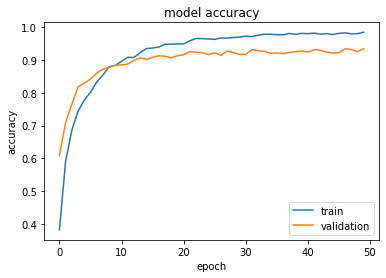

In [49]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

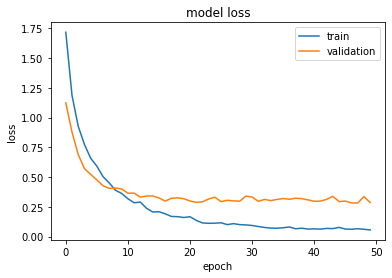

In [50]:
# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

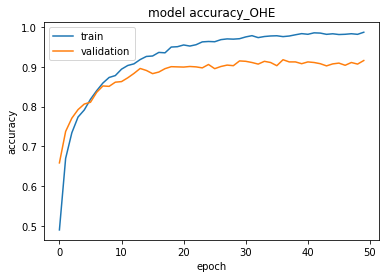

In [51]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history_ohe.history['accuracy'])
plt.plot(history_ohe.history['val_accuracy'])
plt.title('model accuracy_OHE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

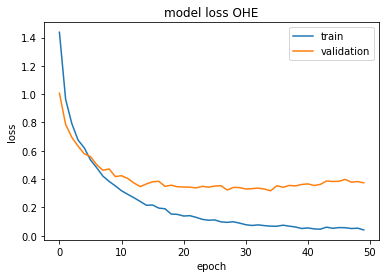

In [52]:
plt.subplots() # open a new plot
plt.plot(history_ohe.history['loss'])
plt.plot(history_ohe.history['val_loss'])
plt.title('model loss OHE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()